In [1]:
import re
import nltk
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Bidirectional, Input, Embedding, LSTM, GRU
from keras import Model
import time
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn import model_selection
import random


In [2]:

class BahdanauAttention(Layer):
    
    def compute_output_shape(self, input_shape):
        return [tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])), tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))]
   
    
    def __init__(self, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W1 = self.add_weight(name = 'W1', shape= tf.TensorShape((input_shape[0][2], input_shape[0][2])), initializer='uniform', trainable=True)
        self.W2 = self.add_weight(name = 'W2', shape = tf.TensorShape((input_shape[1][2], input_shape[0][2])), initializer = 'uniform', trainable=True)
        self.V = self.add_weight(name = 'V', shape = tf.TensorShape((input_shape[0][2], 1)), initializer = 'zeros', trainable=True)

        super(BahdanauAttention, self).build(input_shape)

    def call(self, inputs):
        encoder_output_seq, decoder_output_seq = inputs

        def energy_step(inputs, states):
            encoder_seq_len, encoder_hidden = encoder_output_seq.shape[1], encoder_output_seq.shape[2]
            decoder_hidden = inputs.shape[-1]

            W1_dot_s = keras.backend.dot(encoder_output_seq, self.W1)

            W2_dot_h = keras.backend.expand_dims(keras.backend.dot(inputs, self.W2), 1) 
            Ws_plus_Uh = keras.backend.tanh(W1_dot_s + W2_dot_h)
            e_i = keras.backend.squeeze(keras.backend.dot(Ws_plus_Uh, self.V), axis=-1)
            e_i = keras.backend.softmax(e_i)

            return e_i, [e_i]


        def context_step(inputs, states):
            c_i = keras.backend.sum(encoder_output_seq * keras.backend.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]
    
        fake_state_c = keras.backend.sum(encoder_output_seq, axis=1)
        fake_state_e = keras.backend.sum(encoder_output_seq, axis=2)

        last_out, e_outputs, _  = keras.backend.rnn(energy_step, decoder_output_seq, [fake_state_e],)
        last_out, c_outputs, _ = keras.backend.rnn(context_step, e_outputs, [fake_state_c],)
    
        return c_outputs, e_outputs
  
    

class Chatbot:
    
    def __init__(self, from_dict_size, to_dict_size, latent_dim, embedding_size, max_length_from, max_length_to):
        self.encoder_input = keras.layers.Input(shape=(max_length_from, ), name = 'encoder_input')
        self.decoder_input = keras.layers.Input(shape=(max_length_to, ), name = "decoder_input")
        
        self.encoder_embedding =keras.layers.Embedding(from_dict_size, embedding_size)(self.encoder_input)
        
        self.encoder_lstm = keras.layers.LSTM(latent_dim, return_sequences = True, return_state = True, dropout = 0.6)
       
        self.bidirectional = keras.layers.Bidirectional(self.encoder_lstm, name = 'bidirectional')
        
        self.encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = self.bidirectional(self.encoder_embedding)
        
        state_h = keras.layers.concatenate([fw_state_h, bw_state_h], axis = -1)
        state_c = keras.layers.concatenate([fw_state_c, bw_state_c], axis = -1)
        self.encoder_state = [state_h, state_c]
        
        
        
        self.decoder_embedding = keras.layers.Embedding(to_dict_size, embedding_size)(self.decoder_input)
        self.decoder = keras.layers.LSTM(latent_dim*2, return_sequences = True, return_state = True, dropout = 0.6)
       
        self.decoder_outputs, _, _ = self.decoder(self.decoder_embedding, self.encoder_state)
        self.attention = BahdanauAttention()
        attention_output, attention_state = self.attention([self.encoder_outputs, self.decoder_outputs])
        decoder_concat_input = keras.layers.Concatenate(axis=-1)([self.decoder_outputs, attention_output])

        
        self.dense_output3 = Dense(to_dict_size, activation = 'softmax')
        self.decoder_output = self.dense_output3(decoder_concat_input)
        self.model = Model([self.encoder_input, self.decoder_input], self.decoder_output)
        self.optimizer = keras.optimizers.Adam(learning_rate=0.05)
        self.loss = keras.losses.CategoricalCrossentropy()
        self.model.compile(self.optimizer, self.loss, metrics=["accuracy"])
        
        
    def train(self, encoder_input, decoder_input, decoder_output, encoder_input_val=None, decoder_input_val=None, decoder_output_val=None, batch_size=512, epoch = 3000):
        checkpoint_filepath = 'checkpoint'+ time.strftime("%d%m%y%H%M")+'.h5'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
        
        model_scheduler_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=tf.math.exp(-0.1), patience=3, min_lr=0.00001, cooldown=20, verbose=1)
        model_scheduler_acc = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=tf.math.exp(-0.1), patience=3, min_lr=0.00001, cooldown=20, verbose=1)
        model_scheduler_loss_val = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=tf.math.exp(-0.1), patience=3, min_lr=0.00001, cooldown=20, verbose=1)
        model_scheduler_acc_val = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=tf.math.exp(-0.1), patience=3, min_lr=0.00001, cooldown=20, verbose=1)
        self.history = self.model.fit([encoder_input, decoder_input], decoder_output, batch_size = batch_size, epochs = epoch, callbacks = [ model_scheduler_loss, model_scheduler_acc, model_scheduler_loss_val, model_scheduler_acc_val, model_checkpoint_callback], validation_data = ([encoder_input_val, decoder_input_val], decoder_output_val)) #callbacks = [ model_scheduler_loss, model_scheduler_acc, model_scheduler_loss_val, model_scheduler_acc_val, model_checkpoint_callback])
          
        self.save_model()

    def save_model(self):
        path = "s2s_"+time.strftime("%d%m%y%H%M") + ".h5"
        path_weight = "weight_s2s_"+time.strftime("%d%m%y%H%M") + ".h5"
        model_json = self.model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        self.model.save(path)
        self.model.save_weights(path_weight)
        
    def load_model(self, path):
        json_file = open('../input/model1/model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = keras.models.model_from_json(loaded_model_json)
        self.model.load_weights(path)#self.history = self.model.history()
        
        
    def plot_model_loss(self, epoch = 3000):
        epochs_vals = range(0, epoch)
        losses=self.history.history['loss']
        val_losses=self.history.history['val_loss']
        plt.title('Losses')
        plt.plot(epochs_vals, losses, label='train loss')
        plt.plot(epochs_vals, val_losses, label='validation loss')
        plt.legend(loc='best')
    
    def plot_model_acc(self, epoch = 3000):
        epochs_vals = range(0, epoch)
        acc=self.history.history['accuracy']
        val_acc=self.history.history['val_accuracy']
        plt.title('Accuracy')
        plt.plot(epochs_vals, acc, label='train accuracy')
        plt.plot(epochs_vals, val_acc, label='validation accuracy')
        plt.legend(loc='best')
    
    def form_sentence(self, latent_size, sentence, to_dict_rev, max_answ_length):
        encoder_model, decoder_model = self.inference(latent_size)
        enc_output, state = encoder_model.predict(np.array(sentence))
        target = np.zeros((1, 1))
        target[0,0] = vocab_dict['BOS']
        ind = False
        translation = ''
        while not ind:
            decoder_outputs, state_h, state_c = decoder_model.predict([target] + state)
            attention_output, attention_state = self.attention([enc_output, decoder_outputs])
            decoder_concat_input = tf.keras.layers.Concatenate(axis = -1)([decoder_outputs, attention_output])
            decoder_concat_input = self.dense_output3(decoder_concat_input)    
            from_categorical = np.argmax(decoder_concat_input[0, -1, :])
            
            word_from_categorical = to_dict_rev[from_categorical]+' '
            
            if word_from_categorical != 'EOS ':
                translation += word_from_categorical
                
            if word_from_categorical == 'EOS ' or len(translation.split())>max_answ_length:
                ind = True
                
            target = np.zeros((1, 1))
            target[0,0] = from_categorical
            state = [state_h, state_c]
        
        
        return translation
        
    
    
    def inference(self, latent_size):
        encoder_model = Model(self.encoder_input, [self.encoder_outputs, self.encoder_state])
       
        decoder_input_h = Input(shape=(latent_size*2,))
        decoder_input_c = Input(shape=(latent_size*2,))

        decoder_outputs, state_h, state_c = self.decoder(self.decoder_embedding, [decoder_input_h, decoder_input_c])
        decoder_model = Model([self.decoder_input, [decoder_input_h, decoder_input_c]], [decoder_outputs] + [state_h, state_c])
 
        return encoder_model, decoder_model


def preprocess():
    lines = open("movie_lines.txt","r", encoding='utf-8', errors= "ignore").read().split('\n')
    conversations = open('movie_conversations.txt', 'r', encoding='utf-8', errors = 'ignore').read().split('\n')
    
    movie_lines = {}
    for line in lines:
        line = line.split(' +++$+++ ')
        movie_lines[line[0]] = line[-1]
        
    conversations = [conv.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(',',"").split() for conv in conversations]
    
    questions = []
    answers = []
    
    for conv in conversations:
        for i in range(len(conv)-1):
            questions.append(movie_lines[conv[i]])
            answers.append(movie_lines[conv[i+1]])
            
    return questions, answers


def common_sentence_length(sentences, percentile):
    
    sentence_lengths = [len(line.split()) for line in sentences]
    
    return int(np.percentile(sentence_lengths, percentile))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", r"i am", text)
    text = re.sub(r"\'s", r" is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"thats", r"that is", text)
    text = re.sub(r"\'em", r"them", text)
    text = re.sub(r"gonna", r"going to", text)
    text = re.sub(r"btw", r"by the way", text)
    text = re.sub(r'[^\w\s]', r'', text)
    text = re.sub(r"[!.?,*/|'\_^\+:;<>=#$-`~]", r"", text) 
    text.strip()
    return text


def make_vocabulary(text, threshold=2):
    
    word_count = [['PAD', 0], ['BOS', 1], ['EOS', 2], ['UNK', 3]]
    
    tokenized_text = nltk.tokenize.word_tokenize(text)
    counter = nltk.Counter(tokenized_text)

    counter = [item for item in counter.items() if item[1]>=threshold]

    del(tokenized_text)
    for w, c in counter:
        word_count.append([w, c])
    

    dictionary = {}
    
    for word,_ in word_count:
        dictionary[word] = len(dictionary)
       
    unk_count = 0
    data= []
    for word in text.split():
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count+=1
        data.append(index)
    del(word)
    word_count[0][1] = unk_count
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, word_count, dictionary, reverse_dictionary

def add_bos(texts):
    return ['BOS '+text for text in texts]

def add_eos(texts):
    return [text+" EOS" for text in texts]


def make_encoder_decoder_inputs(questions, answers, dict_from, dict_to):
    encoder_input = []
    decoder_input = []

    for line in questions:
        lst = []
        for word in line.split():
            if word not in dict_from.keys():
                lst.append(dict_from['UNK'])
            else:
                lst.append(dict_from[word])
    
        encoder_input.append(lst)
        del(lst)
    del(line)
    for line in answers:
        lst = []
        for word in line.split():
            if word not in dict_to.keys():
                lst.append(dict_to['UNK'])
            else:
                lst.append(dict_to[word])
        decoder_input.append(lst)
        del(lst)
    
    del(line)
    return encoder_input, decoder_input

def pad_sentences(encoder_inputs, decoder_inputs, encoder_max_sent_length, decoder_max_sent_length, dict_to_size):
    
    encoder_inputs = sequence.pad_sequences(encoder_inputs, encoder_max_sent_length, padding="post", truncating = 'post')
    decoder_inputs = sequence.pad_sequences(decoder_inputs, decoder_max_sent_length, padding="post", truncating = 'post')
    decoder_final_outputs = []

    for di in decoder_inputs:
        decoder_final_outputs.append(di[1:])

    decoder_final_outputs = sequence.pad_sequences(decoder_final_outputs, decoder_max_sent_length, padding='post', truncating = 'post')
    decoder_final_outputs = to_categorical(decoder_final_outputs, dict_to_size)
    return encoder_inputs, decoder_inputs, decoder_final_outputs

def prepare_sentence(sentence, max_sent, vocab):
    sentence = clean_text(sentence)
    sentence_input = []
    for word in sentence.split():
        if word not in vocab.keys():
            sentence_input.append(vocab['UNK'])
        else:
            sentence_input.append(vocab[word])
    
     
    
    return sequence.pad_sequences([sentence_input], max_sent, padding="post", truncating="post")
    
    

In [3]:
questions, answers = preprocess()

clean_questions = [clean_text(q) for q in questions]
clean_answers = [clean_text(a) for a in answers]
del(questions, answers)
pairs = list(zip(clean_questions, clean_answers))
max_quest_length = 20
max_answ_length = 18
del(clean_questions, clean_answers)
questions = [p[0] for p in pairs if len(p[0].split())<=max_quest_length and len(p[1].split())<=max_answ_length and len(p[0].split())>=1 and len(p[1].split())>=1]
answers = [p[1] for p in pairs if len(p[0].split())<=max_quest_length and len(p[1].split()) <=max_answ_length and len(p[0].split())>=1 and len(p[1].split())>=1]



In [4]:
vocab_data, vocab_word_count, vocab_dict, vocab_dict_rev = make_vocabulary(' '.join(questions + answers), 12)

In [5]:
answers = add_bos(answers)

answers = add_eos(answers)

In [6]:
encoder_input, decoder_input = make_encoder_decoder_inputs(questions[:50000], answers[:50000], vocab_dict, vocab_dict)


In [7]:
test_size = int(len(encoder_input)*0.2)
val_size  = int((len(encoder_input)-test_size)*0.2)
encoder_input_test, decoder_input_test = encoder_input[:test_size], decoder_input[:test_size]
encoder_input_val, decoder_input_val = encoder_input[test_size: test_size + val_size], decoder_input[test_size: test_size + val_size]
encoder_input_train, decoder_input_train = encoder_input[ test_size +val_size:], decoder_input[ test_size+val_size:]
encoder_input_train, decoder_input_train, decoder_output_train = pad_sentences(encoder_input_train, decoder_input_train, max_quest_length, max_answ_length+2, len(vocab_dict))
encoder_input_val, decoder_input_val, decoder_output_val = pad_sentences(encoder_input_val, decoder_input_val, max_quest_length, max_answ_length+2, len(vocab_dict))



In [8]:
model = Chatbot(len(vocab_dict), len(vocab_dict), 128, 50, max_quest_length,max_answ_length+2)
del(questions)
del(answers)
del(encoder_input)
del(decoder_input)

2021-11-17 15:26:09.734277: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN

In [9]:
print(model.model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 50)       359150      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 20)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 20, 256), (N 183296      embedding[0][0]                  
______________________________________________________________________________________________

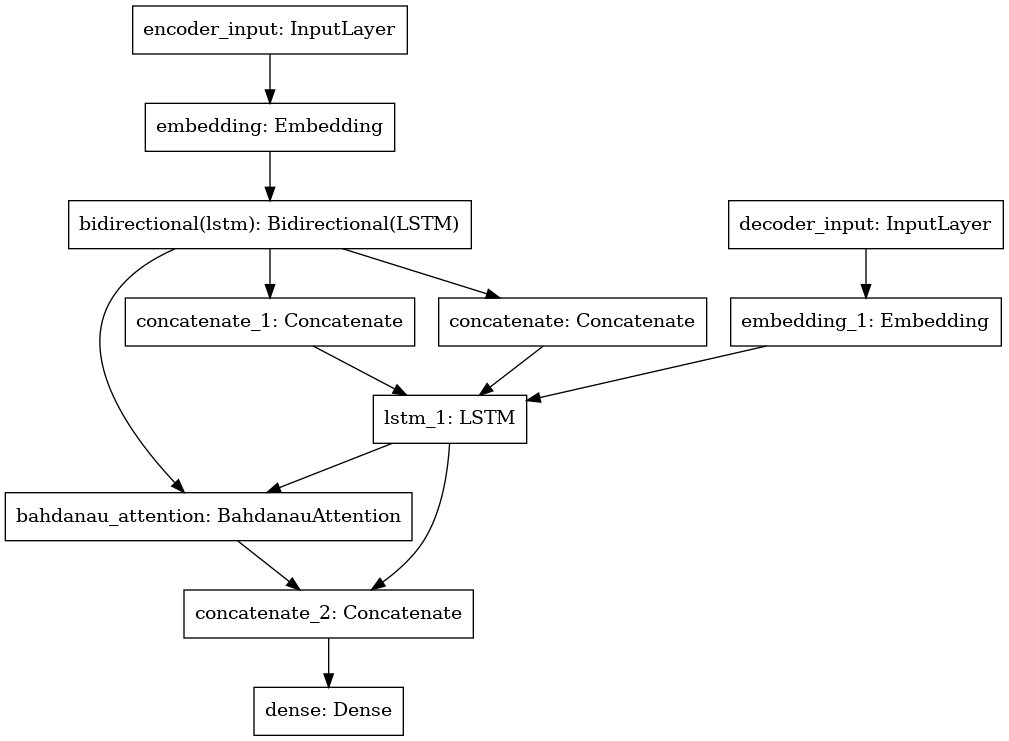

In [10]:
plot_model(model.model)

In [11]:
model.train(encoder_input = encoder_input_train, decoder_input = decoder_input_train, decoder_output = decoder_output_train, encoder_input_val = encoder_input_val, decoder_input_val = decoder_input_val, decoder_output_val = decoder_output_val, batch_size = 1024, epoch = 200)

2021-11-17 15:26:17.740451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
32/32 [==============================] - 90s 3s/step - loss: 4.2159 - accuracy: 0.5106 - val_loss: 2.4889 - val_accuracy: 0.6448
Epoch 2/200
32/32 [==============================] - 80s 3s/step - loss: 2.2832 - accuracy: 0.6531 - val_loss: 2.2496 - val_accuracy: 0.6575
Epoch 3/200
32/32 [==============================] - 80s 2s/step - loss: 2.1148 - accuracy: 0.6660 - val_loss: 2.1184 - val_accuracy: 0.6714
Epoch 4/200
32/32 [==============================] - 80s 2s/step - loss: 2.0026 - accuracy: 0.6752 - val_loss: 2.0466 - val_accuracy: 0.6764
Epoch 5/200
32/32 [==============================] - 80s 3s/step - loss: 1.9276 - accuracy: 0.6811 - val_loss: 2.0055 - val_accuracy: 0.6819
Epoch 6/200
32/32 [==============================] - 80s 3s/step - loss: 1.8751 - accuracy: 0.6851 - val_loss: 1.9754 - val_accuracy: 0.6844
Epoch 7/200
32/32 [==============================] - 80s 3s/step - loss: 1.8338 - accuracy: 0.6874 - val_loss: 1.9657 - val_accuracy: 0.6852
Epoch 8/200
3

In [13]:
del(encoder_input_val, decoder_input_val, decoder_output_val)

In [14]:
encoder_input_test1, decoder_input_test1, decoder_output_test1 = pad_sentences(encoder_input_test, decoder_input_test, max_quest_length, max_answ_length+2, len(vocab_dict))


In [ ]:
model.model.evaluate([encoder_input_test1, decoder_input_test1], decoder_output_test1)

In [15]:
sentence = ''
while 1:
    sentence = input('user:')
    if(sentence=='quit'):
        break
        
    sentence = prepare_sentence(sentence, 20, vocab_dict)
    
    translation = model.form_sentence(128, sentence, vocab_dict_rev, 18)
    print('chatbot: '+translation)

user: hi


chatbot: hi 


user: do you want some coffee


chatbot: i do not know 


user: quit
